#Multi label Perceptron with pocket implementation

implemented using numpy. used to classify MNIST dataset.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
WEIGHTS_SIZE=784
LABELS_SIZE=10

In [8]:
# Utility functions

def one_hot_encode(labels):
  """
    One hot encode labels 3=>[0,0,0,1,0,0,0,0,0,0]
  """
  one_hot_encoded=np.zeros((labels.size,LABELS_SIZE))
  one_hot_encoded[np.arange(labels.size),labels]=1

  return one_hot_encoded

def get_error_count(labels,preds):
  """
    get error count true labels and the predictions
  """
  return len(np.where(np.argmax(labels,axis=1)!=np.argmax(preds,axis=0))[0])

def format_percent(num,denom):
  """
    format percentage for printing the predictions
    send numerator denominator get the percentage
  """
  frac=num/denom if denom!=0 else 1
  return '{0:.2f}'.format(frac*100 if frac<=1 and frac>=0 else frac)

In [6]:
from sys import maxsize
import matplotlib.pyplot as plt
import numpy as np

# initial constants
WEIGHTS_SIZE=784
EPOCHS=100
LR=1

class MultiLabelPerceptron:

  def __init__(self,X_train,y_train,X_test,y_test,epochs=EPOCHS,lr=LR):
    self.X_train=X_train
    self.y_train=y_train
    self.X_test=X_test
    self.y_test=y_test
    # Init weights and bias vector list with uniform distribution
    self.weights=np.array([np.concatenate(([0], np.random.rand(WEIGHTS_SIZE))) for i in range(10)])
    # Keep the best weights so far
    self.pocket=np.copy(self.weights)
    self.pocket_error_count=maxsize
    # Keep track model losses in training to plot a loss curve
    self.losses=[]
    # Init number of epochs and learning rate
    self.epochs=epochs
    self.lr=lr


  def train(self):
    for epoch in range(self.epochs):

      # Calculate all train predictions
      preds=np.dot(self.weights,self.X_train)
      # Calculate all test predictions
      test_label_preds=np.dot(self.weights,self.X_test)
      # Calculate test and train error counts
      train_error_count=get_error_count(self.y_train,preds)
      test_error_count=get_error_count(self.y_test,test_label_preds)

      test_error_part=(test_error_count/len(self.y_test))
      train_error_part=(train_error_count/len(self.y_train))
      # Init train counters
      train_error_counters=np.zeros(10)

      if self.pocket_error_count > test_error_count:
        self.pocket_error_count=test_error_count
        self.pocket=np.copy(self.weights)

      self.losses.append(np.array([train_error_part,test_error_part,self.pocket_error_count/len(self.y_test)]))

      print("------------------------------------------------------------------------------------------------------------------------------")
      print(f"Epoch {epoch+1} of total {self.epochs}\t|\tTrain accuracy:{format_percent(len(y_train)-train_error_count,len(self.y_train))}\t|\tTest accuracy:{format_percent(len(self.y_test)-test_error_count,len(self.y_test))}\t|\tTest pocket accuracy:{format_percent(len(self.y_test)-self.pocket_error_count,len(self.y_test))}")
      print("------------------------------------------------------------------------------------------------------------------------------")

      if test_error_count ==0 :
        # there is nothing more to learn
        break
      # TODO: find classier method to do so.
      # Learning process for each classifier
      for i in range(len(preds)):
        # for each sample
        for j in range(len(preds[i])):
          if y_train[j][i] != 1 and preds[i][j]>=0: # misclassified prediction - false positive
            # W(t+1)=W(t)-y(t)*x(t)
            train_error_counters[i]+=1
            self.weights[i]-=self.lr*X_train[:,j]
          elif y_train[j][i] == 1 and preds[i][j]<0: # misclassified prediction - false negative
            # W(t+1)=W(t)+y(t)*x(t)
            train_error_counters[i]+=1
            self.weights[i]+=self.lr*X_train[:,j]
      for digit in range(len(train_error_counters)):
        print(f"classifier for digit {digit}\t|\tTrain accuracy:{format_percent(self.X_train.shape[1]-train_error_counters[digit],self.X_train.shape[1])}")

  def predict(self,x):
    """
    Predict labels for given X vector
    """
    return np.argmax(np.dot(self.pocket,X_test),axis=0)

  def plot_loss_curve(self):
    self.losses=np.array(self.losses)
    plt.title("loss over iterations")
    plt.ylim(0,1)
    plt.xlim(1,self.epochs)
    plt.plot(np.array(self.losses)[:,0], linestyle='solid', color='b', label='Train accuracy')
    plt.plot(np.array(self.losses)[:,1], linestyle='solid', color='r', label='Test accuracy')
    plt.plot(np.array(self.losses)[:,2], linestyle='solid', color='g', label='Pocket accuracy')
    plt.legend()
    plt.show()

  def compute_confusion_mat(self):
      """
      Compute and print the confusion matrixes on test data
      """
      test_label_preds = self.predict(self.X_test)
      zipped=list(zip(test_label_preds, np.argmax(self.y_test,axis=1)))
      # Confusion matrix for each classifier
      for i in range(len(self.weights)):
          tn = len(list(filter(lambda l: l[0] != i and l[1] != i, zipped)))
          fn = len(list(filter(lambda l: l[0] == i and l[1] != i, zipped)))
          tp = len(list(filter(lambda l: l[0] == i and l[1] == i, zipped)))
          fp = len(list(filter(lambda l: l[0] != i and l[1] == i, zipped)))

          print("------------------------------------------------------------------------------------------------------------------")
          print(f"--------\tConfusion Matrix for digit {i}\t--------")
          print("------------------------------------------------------------------------------------------------------------------")
          print("\t|\tTrue\t|\tFalse")
          print("---------------------------------------------")
          print(f"Positive|\t{tp}\t|\t{fp}")
          print(f"Negative|\t{tn}\t|\t{fn}")
          print("------------------------------------------------------------------------------------------------------------------")
          print(f"Accuracy: {format_percent(tp+tn,tp+tn+fp+fn)}\t|\tSensitivity: {format_percent(tp,tp+fn)}\t|\tSelectivity: {format_percent(tn,tn+fp)}")
          print("------------------------------------------------------------------------------------------------------------------\n\n")

      # Compute confusion matrix for multi label model
      confusion_matrix = [[0] * len(self.weights) for _ in range(len(self.weights))]
      for true_label, predicted_label in zipped:
          confusion_matrix[predicted_label][true_label] += 1
      # Print matrix
      print("Confusion Matrix:")
      print("Predicted\Actual", end="\t")
      for i in range(len(confusion_matrix)):
          print(f"Digit {i}", end="\t")
      print()

      for i in range(len(confusion_matrix)):
          print(f"Digit {i}", end="\t\t\t")
          for j in range(len(confusion_matrix[i])):
              print(confusion_matrix[i][j], end="\t")
          print()

In [7]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto')
# Access features (pixel values) and labels
X, y = mnist['data'], mnist['target']

# Convert X,y to numpy arrays
X, y = X.to_numpy(dtype=float), y.to_numpy(dtype=int)

# One hot encode y
y = one_hot_encode(y)

# Append 1 to each sample for the bias
X = np.array(list(map(lambda sample: np.append([1], sample), X)))


# Split dataset into train and test sets 60k train and 10k test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 / 7)

# Transpose X vector to match shape
X_train,X_test = X_train.T,X_test.T



In [9]:
# Init perceptron instance and train it

p1=MultiLabelPerceptron(X_train,y_train,X_test,y_test)
p1.train()

------------------------------------------------------------------------------------------------------------------------------
Epoch 1 of total 100	|	Train accuracy:5.08	|	Test accuracy:5.20	|	Test pocket accuracy:5.20
------------------------------------------------------------------------------------------------------------------------------
classifier for digit 0	|	Train accuracy:9.89
classifier for digit 1	|	Train accuracy:11.27
classifier for digit 2	|	Train accuracy:9.98
classifier for digit 3	|	Train accuracy:10.08
classifier for digit 4	|	Train accuracy:9.80
classifier for digit 5	|	Train accuracy:9.11
classifier for digit 6	|	Train accuracy:9.77
classifier for digit 7	|	Train accuracy:10.36
classifier for digit 8	|	Train accuracy:9.72
classifier for digit 9	|	Train accuracy:10.02
------------------------------------------------------------------------------------------------------------------------------
Epoch 2 of total 100	|	Train accuracy:67.16	|	Test accuracy:68.47	|	Test 

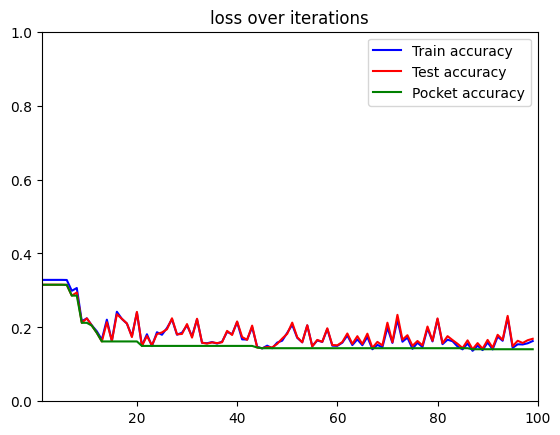

In [10]:
p1.plot_loss_curve()

In [11]:
p1.compute_confusion_mat()

------------------------------------------------------------------------------------------------------------------
--------	Confusion Matrix for digit 0	--------
------------------------------------------------------------------------------------------------------------------
	|	True	|	False
---------------------------------------------
Positive|	919	|	47
Negative|	8966	|	68
------------------------------------------------------------------------------------------------------------------
Accuracy: 98.85	|	Sensitivity: 93.11	|	Selectivity: 99.48
------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------
--------	Confusion Matrix for digit 1	--------
------------------------------------------------------------------------------------------------------------------
	|	True	|	False
---------------------------------------


# Conclusion

as i look at the confusion tables for each classifier each has a great accuracy and selectivity meters, two classifiers stood out with quite low sensitivity meter on both the digits **8** and **5**.
from the confusion matrix for all classifiers i can see that it has a lot of mistakes on those two digits - it hasn't learned it as well as the other digits at **8** it had a lot of fn on the digit **2** and on **5** it had a lot of fn on the digit **3**. i think that i would use this classifier for all the digits and if it's either one of 5 or 8 i would transfer it to human examination.
to the most part the learning converged i think these are nice results.